In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [31]:
#0.Importing required packages 
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sys
import traceback
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import stattools
from scipy import signal
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.pipelines.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from itertools import product
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5
import pandas as pd
import numpy as np
from datetime import datetime
from fedot.core.data.multi_modal import MultiModalData
# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5
import statsmodels.tsa.api as smt
from tabulate import tabulate

## Step 01: Preparing Data

In [4]:
#1.Reading Data 
energydata = pd.read_csv("./energydata_complete.csv")
#2.Creating subsamples 
#2.1.Choosing colomns .. Target is T2,Tout
sample_energydata=energydata[[ 'date','T2', 'T5','T6','T_out']]
df_sample_colomn_energydata = pd.DataFrame(sample_energydata)

In [5]:
#timestamps to daily
df_sample_colomn_energydata['date']=pd.to_datetime(df_sample_colomn_energydata['date'], infer_datetime_format=True )
df_sample_colomn_energydata['date']=df_sample_colomn_energydata['date'].dt.round('1h')  

In [6]:
# Aggregation data and indexing
df_daily=df_sample_colomn_energydata.groupby('date', as_index=False).agg({"T2": "median","T5": "median","T6": "median","T_out": "median" }) # median
df_daily=df_daily.sort_values('date')
df_daily.index=pd.date_range(freq="h",start=df_daily["date"][0],periods=len(df_daily['date']))

In [7]:
# Aggregation data without indexing
df_daily_noindex =df_sample_colomn_energydata.groupby('date', as_index=False).agg({"T2": "median","T5": "median","T6": "median","T_out": "median" }) # median
df_daily_noindex=df_daily_noindex.sort_values('date')

## Step 02: Stationarity of a process (for mathematical expectation and variance)

In [8]:
# Defining a function to plot and write stationarity information
def stationarity(col_name,df):
    #plotting
    plt.figure(figsize=(8, 6))
    plt.plot(df['date'],df[col_name])
    plt.xticks(rotation=45)
    plt.xlabel(u'Date', fontsize = 20)
    plt.ylabel(u'Mean', fontsize = 20)
    plt.title(col_name, fontsize = 20)
    # Testing , lower p-value --> more stationary
    result = smt.stattools.adfuller(df[col_name])
    print(col_name+': Augmented Dickey-Fuller test:\nStatistic value = %5f\np-value = %5f' % (result[0], result[1]))
    #moving average
    result = seasonal_decompose((df[col_name]), model='additive')
    fig=result.plot()
    fig.set_figheight(6)
    fig.set_figwidth(14)
    plt.show()
    return df

### Variable T2

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


T2: Augmented Dickey-Fuller test:
Statistic value = -7.235371
p-value = 0.000000


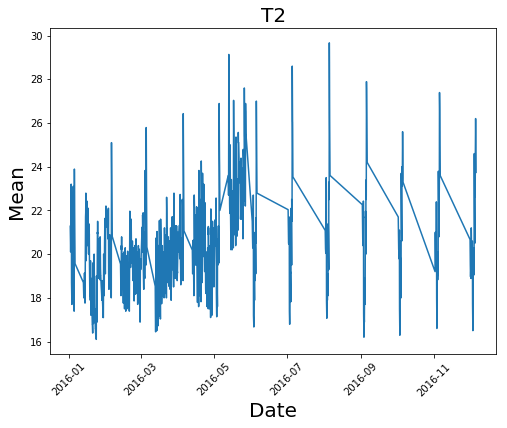

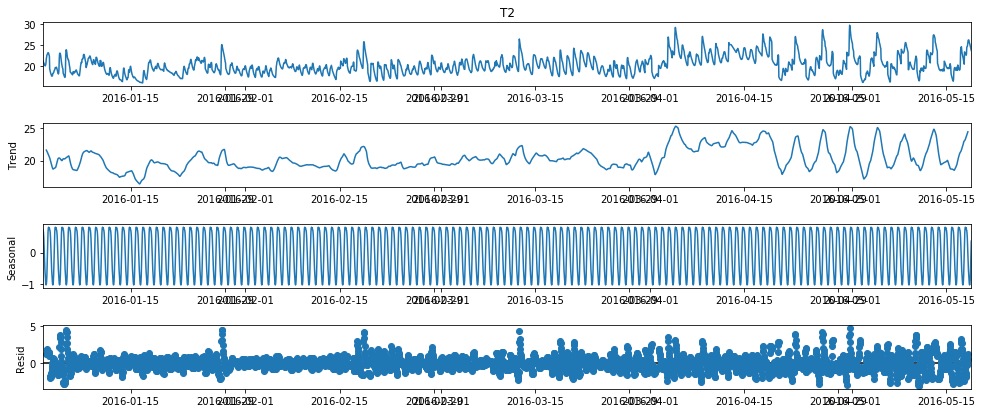

In [33]:
df_daily_T2=stationarity('T2',df_daily)

In [ ]:
result = smt.stattools.adfuller((df_sample_colomn_energydata['T2']))
print('Augmented Dickey-Fuller test:\nStatistic value = %5f\np-value = %5f' % (result[0], result[1]))

### T2 variable for half of the data
After observing the Mean-Date plot of the variable T2, I choose only the left side of the data to be worked on

In [9]:
# Dividing Data to 2 parts
half_data=df_daily[df_daily.date < datetime(2016,6,1)] # after the result of T2

T2: Augmented Dickey-Fuller test:
Statistic value = -3.887122
p-value = 0.002132


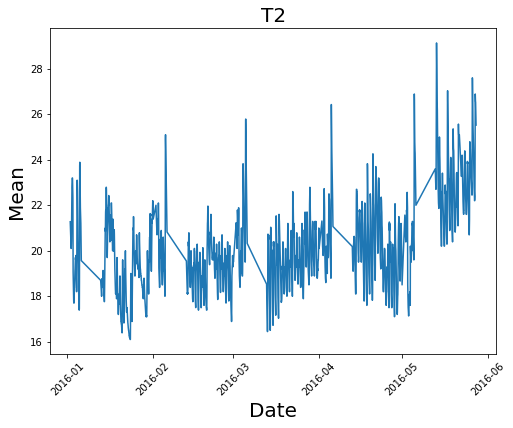

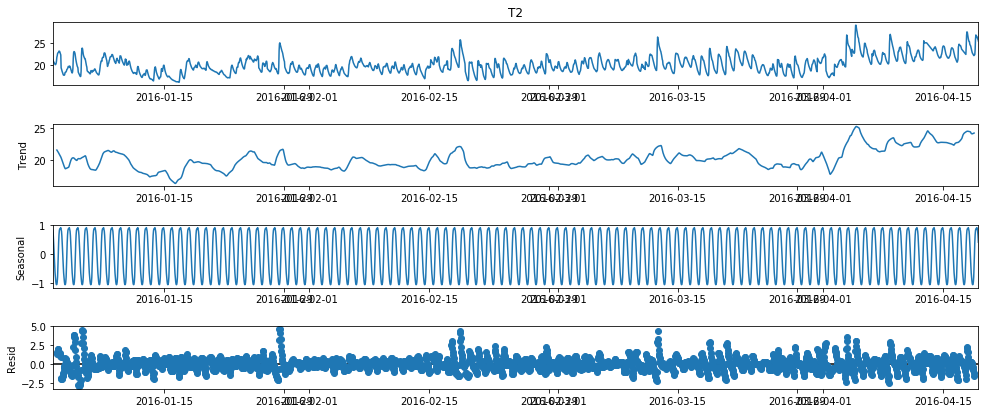

In [10]:
# Checking the stationarity of T2 again after taking the half of data
df_daily_T2_half=stationarity('T2',half_data)

In [11]:
# taking the half of data of the non indexed data
half_data_noindex=df_daily_noindex[df_daily_noindex.date < datetime(2016,6,1)] 

In [12]:
# defining a function to find the trend
def trendline(data, order=9):
    #polynomial trend
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)


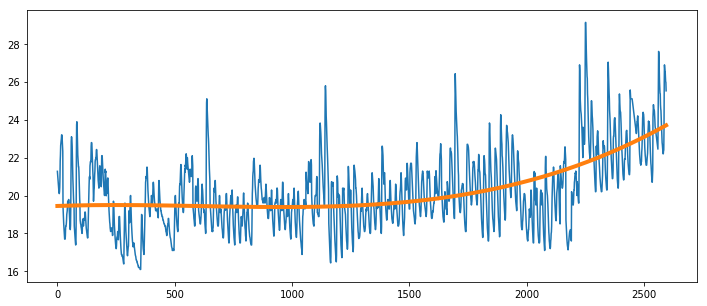

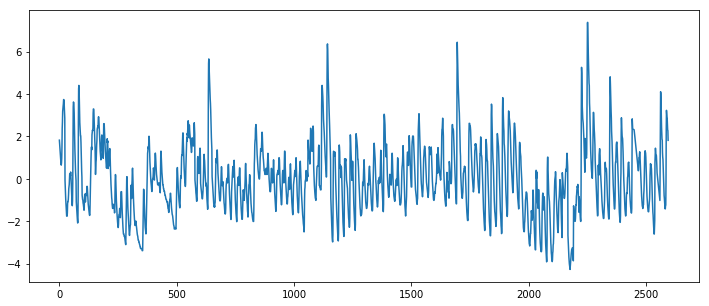

In [13]:
trend = trendline(half_data_noindex['T2'], 3) # finding the trend
plt.plot(half_data_noindex['T2'])   #plotting the data
plt.plot(trend, linewidth=4)  # plotting the trend
plt.show()
newT2=half_data_noindex['T2']-trend  # deleting the trend from the column
plt.plot(half_data_noindex['T2']-trend) # plotting after deleting the trend
plt.show()

### T5, Repeating the steps applied for the variable T2 (Deleting Trend)

T5: Augmented Dickey-Fuller test:
Statistic value = -2.711019
p-value = 0.072151


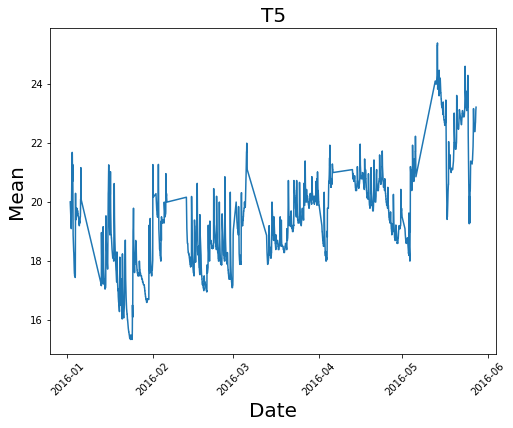

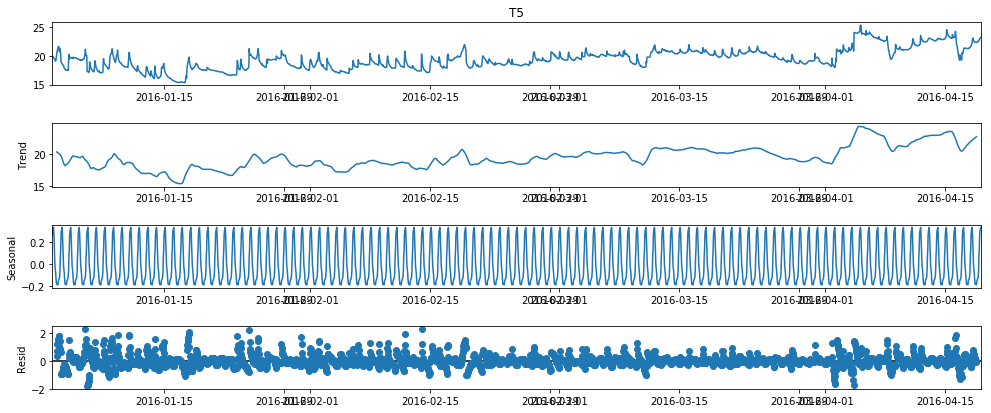

In [14]:
df_daily_T5=stationarity('T5',half_data) 

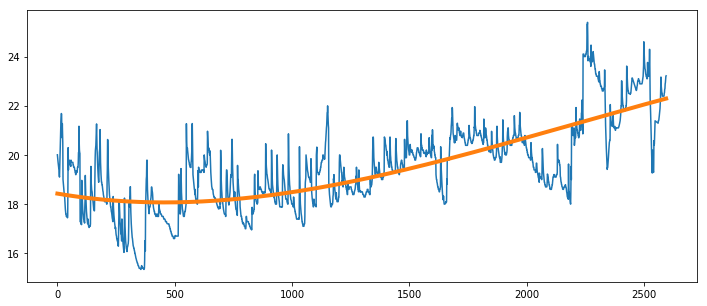

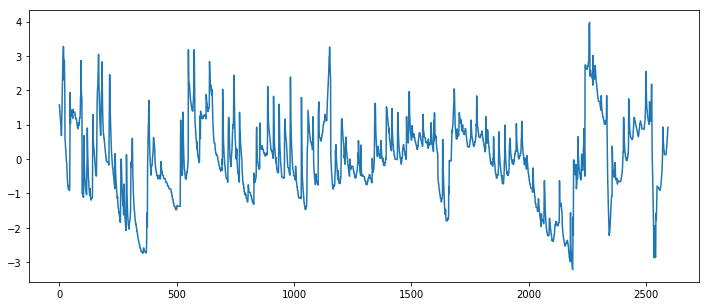

In [15]:
trend = trendline(half_data_noindex['T5'], 3)
plt.plot(half_data_noindex['T5'])#
plt.plot(trend, linewidth=4)
plt.show()
newT5=half_data_noindex['T5']-trend
plt.plot(half_data_noindex['T5']-trend)
plt.show()

### T6, Repeating the steps applied for the variable T2 (Deleting Trend)

T6: Augmented Dickey-Fuller test:
Statistic value = -3.830888
p-value = 0.002607


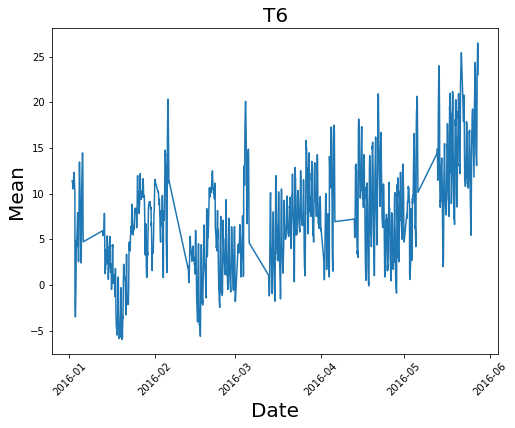

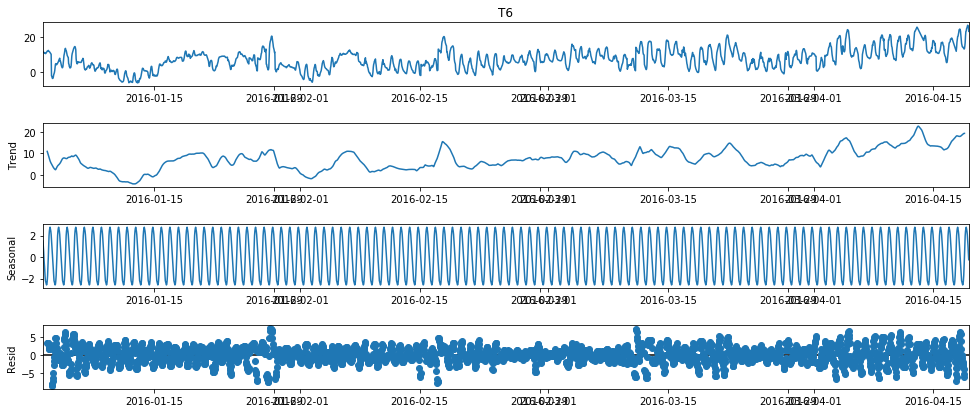

In [16]:
df_daily_T6=stationarity("T6",half_data)

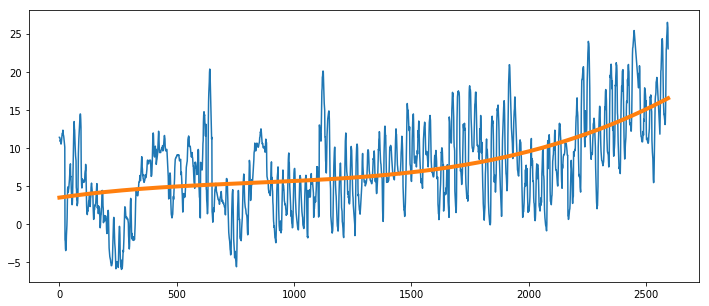

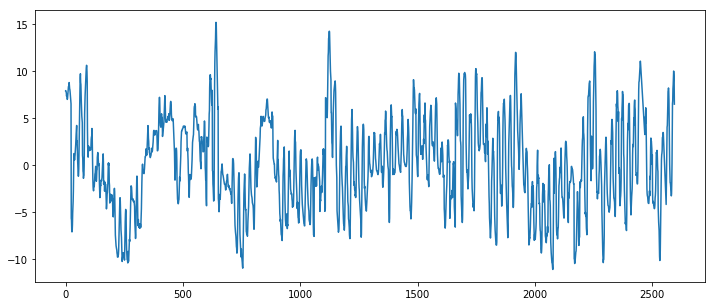

In [17]:
trend = trendline(half_data_noindex['T6'], 3)
plt.plot(half_data_noindex['T6'])
plt.plot(trend, linewidth=4)
plt.show()
newT6=half_data_noindex['T6']-trend
plt.plot(half_data_noindex['T6']-trend)
plt.show()

### T_out, Repeating the steps applied for the variable T2 (Deleting trend)

T_out: Augmented Dickey-Fuller test:
Statistic value = -3.777386
p-value = 0.003147


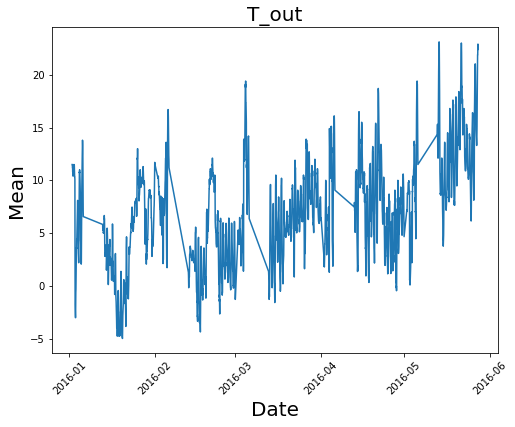

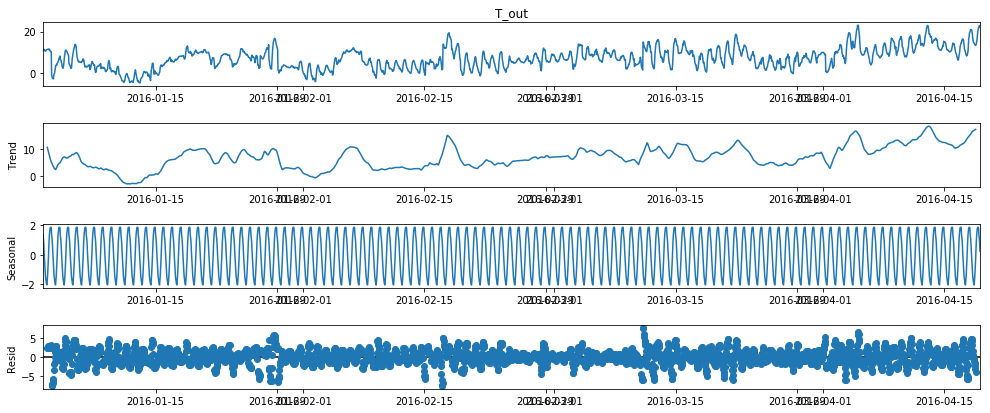

In [18]:
df_daily_Tout=stationarity("T_out",half_data)

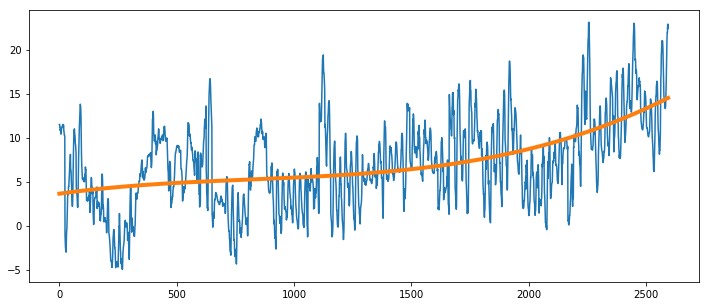

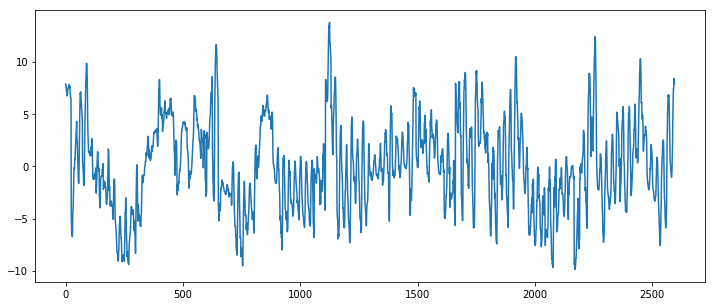

In [19]:
def trendline(data, order=9):
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)
trend = trendline(half_data_noindex['T_out'], 3)
plt.plot(half_data_noindex['T_out'])
plt.plot(trend, linewidth=4)
plt.show()
newT_out=half_data_noindex['T_out']-trend
plt.plot(half_data_noindex['T_out']-trend)
plt.show()

### Checking the stationarity after deleting the trends in the previous steps.

#### preparing the data

In [106]:
# creating a dataset out of the column where the trend were deleted.
data_stationary = {'date': df_daily_noindex['date'],
            'T2': newT2,
            'T5': newT5,
            'T6': newT6,
            'T_out': newT_out}  
data_stationary = pd.DataFrame(data_stationary)  
# Print the output.  
print(data_stationary)  

                    date        T2        T5        T6     T_out
0    2016-01-02 00:00:00  1.826422  1.576922  7.924815  7.863993
1    2016-01-02 01:00:00  1.650995  1.463000  7.920350  7.860269
2    2016-01-02 02:00:00  1.440571  1.364629  7.825893  7.556551
3    2016-01-02 03:00:00  1.250148  1.276255  7.681443  7.552839
4    2016-01-02 04:00:00  1.149728  1.177877  7.347001  7.149134
...                  ...       ...       ...       ...       ...
3301 2016-12-05 20:00:00       NaN       NaN       NaN       NaN
3302 2016-12-05 21:00:00       NaN       NaN       NaN       NaN
3303 2016-12-05 22:00:00       NaN       NaN       NaN       NaN
3304 2016-12-05 23:00:00       NaN       NaN       NaN       NaN
3305 2016-12-06 00:00:00       NaN       NaN       NaN       NaN

[3306 rows x 5 columns]


In [24]:
# Checking if there is null values and deleting them
data_stationary.isnull().sum()
data_stationary = data_stationary.dropna()
# make the new created data time indexed
data_stationary.index=pd.date_range(freq="h",start=data_stationary["date"][0],periods=len(data_stationary['date']))

#### checking stationanarity after removing trend for each variable

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


T2: Augmented Dickey-Fuller test:
Statistic value = -6.274650
p-value = 0.000000


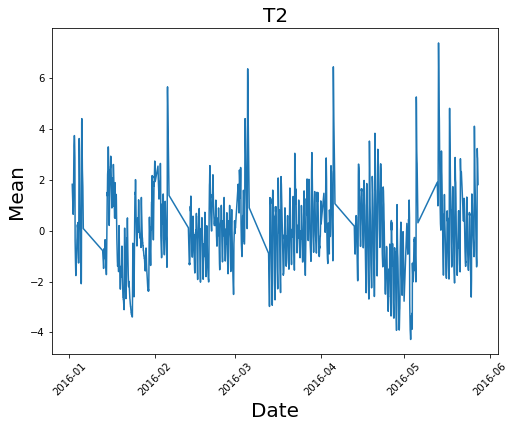

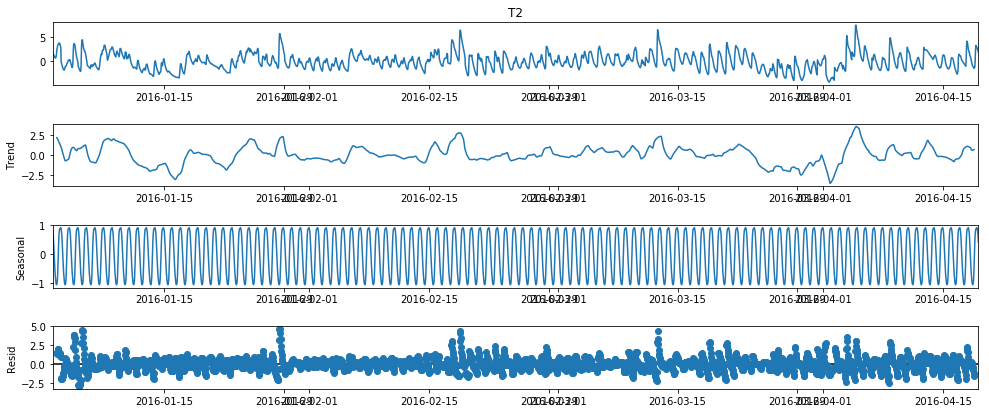

In [ ]:
df_daily_T2_half_stationarity=stationarity('T2',data_stationary)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


T5: Augmented Dickey-Fuller test:
Statistic value = -5.496873
p-value = 0.000002


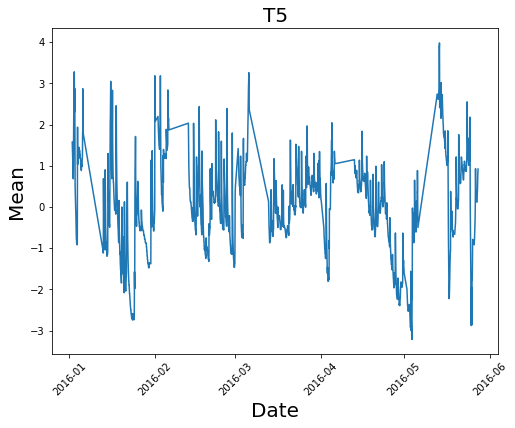

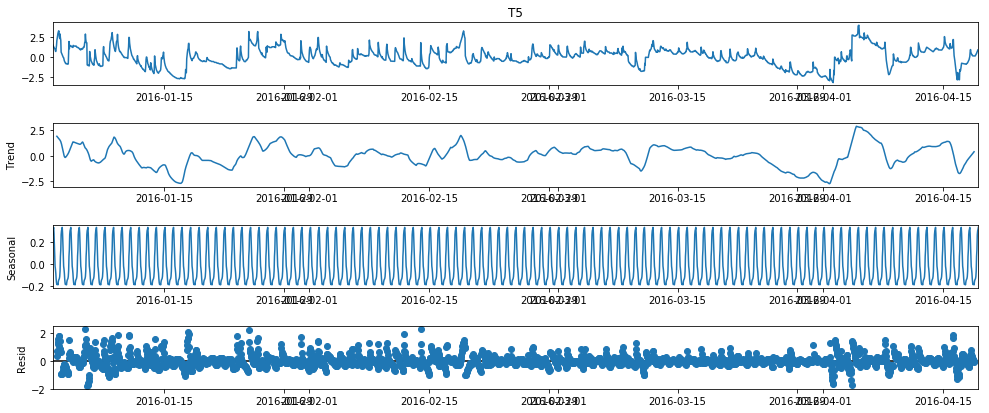

In [146]:
df_daily_T2_half_stationarity=stationarity('T5',data_stationary)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


T6: Augmented Dickey-Fuller test:
Statistic value = -5.671630
p-value = 0.000001


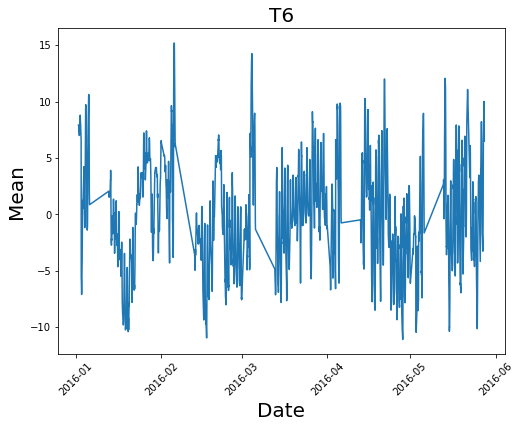

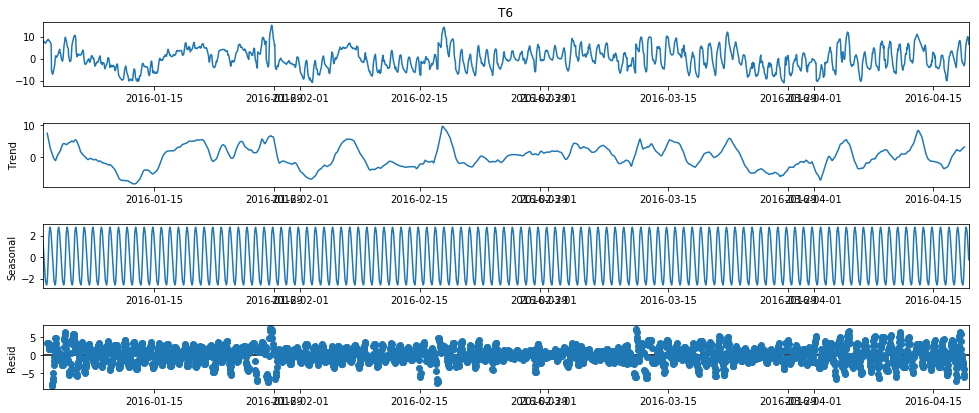

In [147]:
df_daily_T2_half_stationarity=stationarity('T6',data_stationary)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1418: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


T_out: Augmented Dickey-Fuller test:
Statistic value = -5.465004
p-value = 0.000002


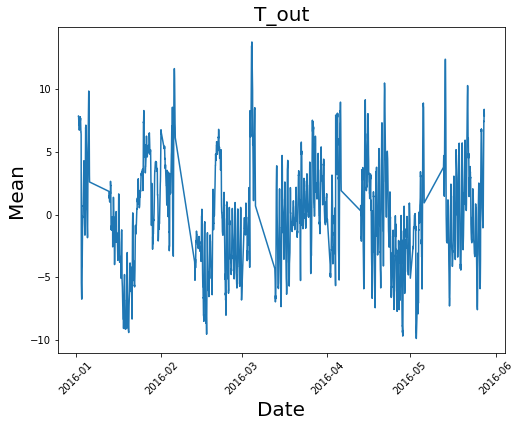

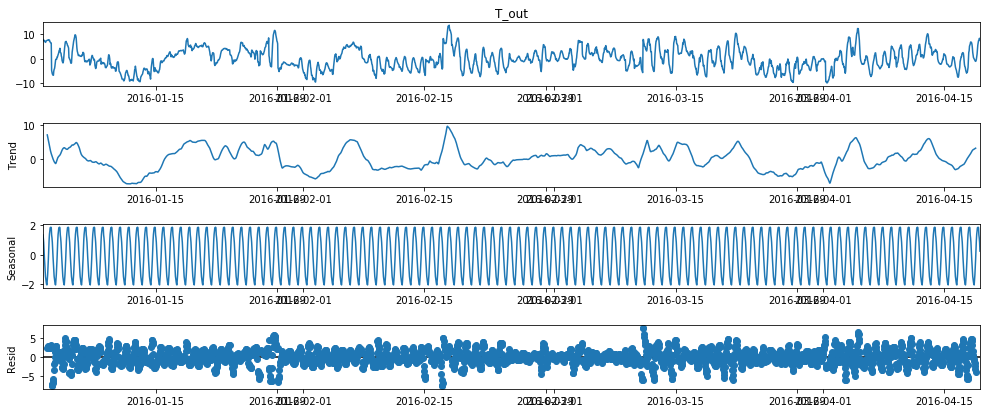

In [148]:
df_daily_T2_half_stationarity=stationarity('T_out',data_stationary)

## Step 03: Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets

### Covariance for Targets : T2 , T_out

In [137]:
data_stationary['T2']

0       1.826422
1       1.650995
2       1.440571
3       1.250148
4       1.149728
          ...   
2591    2.864940
2592    2.595244
2593    2.311255
2594    2.282402
2595    1.818828
Name: T2, Length: 2596, dtype: float64

Text(0.5, 1.0, 'T2')

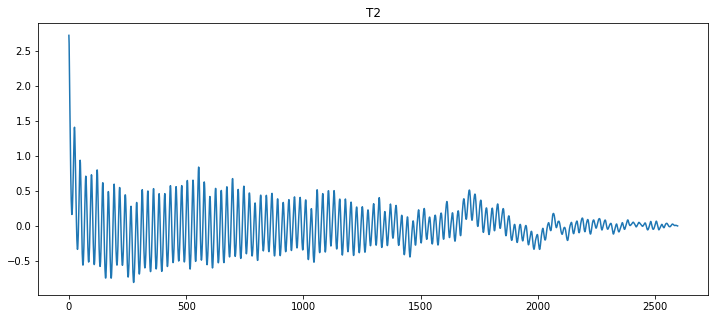

In [138]:
plt.plot(stattools.acovf(data_stationary['T2'],fft=False)) #autocovariance without window
plt.title("T2")

Text(0.5, 1.0, 'Tout')

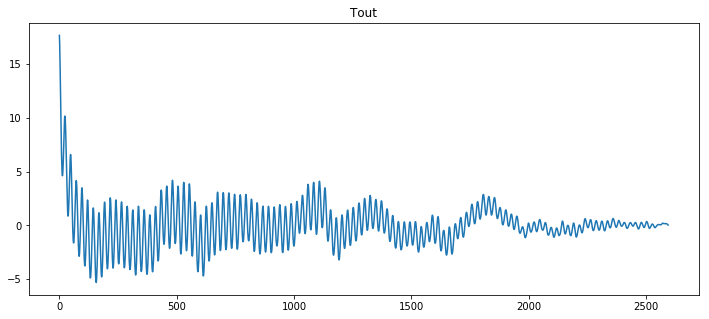

In [139]:
plt.plot(stattools.acovf(data_stationary['T_out'],fft=False)) #autocovariance without window
plt.title("Tout")

### Mutual correlation functions among predictors and targets

In [28]:
# calculating var (t-1) from var (t) by shifting the var list one step
T2_previous_t=np.roll(data_stationary['T2'],1)  # target
T5_previous_t=np.roll(data_stationary['T5'],1)  # predictor
T6_previous_t=np.roll(data_stationary['T6'],1)  # predictor
T_out_previous_t=np.roll(data_stationary['T_out'],1) # target

In [41]:
# creating a dataset out of the var (t) and var (t-1)
data_correlated = {
            'T2': data_stationary['T2'],
            'T2 (t-1)': T2_previous_t,
            'T5': data_stationary['T5'],
            'T5 (t-1)': T5_previous_t,
            'T6': data_stationary['T6'],
            'T6 (t-1)': T6_previous_t,
            'T_out': data_stationary['T_out'],
            'T_out (t-1)': T_out_previous_t}  
data_correlated = pd.DataFrame(data_correlated)  

In [45]:
# finding mutual correlation for the data var (t) and var (t-1)
data_correlated.corr()

,T2,T2 (t-1),T5,T5 (t-1),T6,T6 (t-1),T_out,T_out (t-1)
T2,1.000000,0.957373,0.532299,0.498214,0.660134,0.657862,0.644415,0.622001
T2 (t-1),0.957373,1.000000,0.552327,0.532299,0.623681,0.660134,0.634448,0.644415
T5,0.532299,0.552327,1.000000,0.966621,0.295374,0.323676,0.343222,0.367816
T5 (t-1),0.498214,0.532299,0.966621,1.000000,0.261653,0.295374,0.311533,0.343222
T6,0.660134,0.623681,0.295374,0.261653,1.000000,0.968344,0.963287,0.918560
T6 (t-1),0.657862,0.660134,0.323676,0.295374,0.968344,1.000000,0.958351,0.963287
T_out,0.644415,0.634448,0.343222,0.311533,0.963287,0.958351,1.000000,0.969213
T_out (t-1),0.622001,0.644415,0.367816,0.343222,0.918560,0.963287,0.969213,1.000000


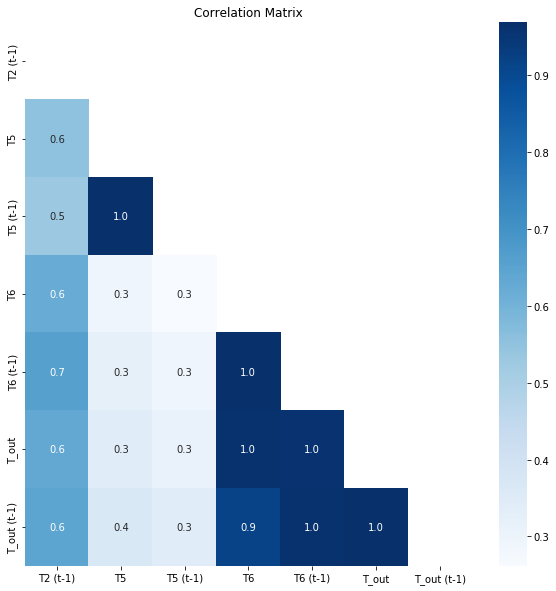

In [46]:
#Pair correlation coefficients, Correlation Matrix for the data var (t) and var (t-1)
fig, ax = plt.subplots(figsize=(10,10))
corr = data_correlated[data_correlated.columns[1:]].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True,  fmt='.1f',ax=ax, cmap = 'Blues')
plt.title('Correlation Matrix')
plt.show()

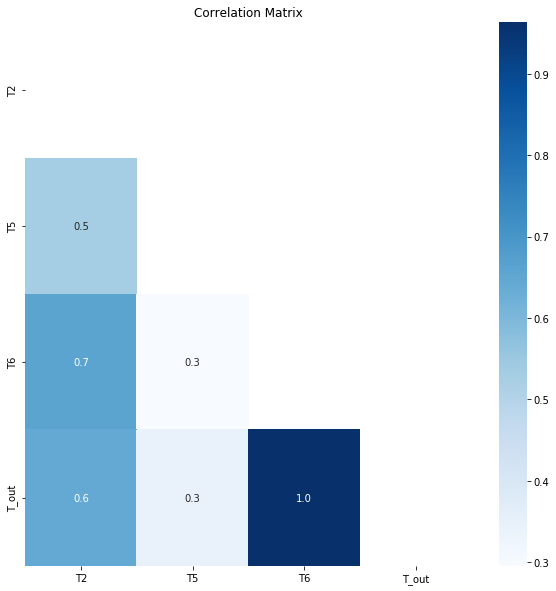

In [48]:
#Pair correlation coefficients, Correlation Matrix, for the data var (t)
fig, ax = plt.subplots(figsize=(10,10))
corr = data_stationary[data_stationary.columns[1:]].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True,  fmt='.1f',ax=ax, cmap = 'Blues')
plt.title('Correlation Matrix')
plt.show()

## Step 04: Filter high frequencies (noise) with chosen 2 filters for target variables

### T2 Filtering

In [49]:
# Data preperation
# Convert into numpy array first
time_series=np.array(data_stationary["T2"])
#FEDOT data preparation
# Define task - time series forecasting
# and forecast horizon 
task=Task (TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=25))
input_data = InputData(idx=np.arange(0, len(time_series)),
features=time_series, target=time_series,
task=task, data_type=DataTypesEnum.ts)

#### T2 Rolling Mean Filtering

In [50]:
# Rolling mean window smoothing
def Rolling_T2(window_size):
    smoothing_node = PrimaryNode('smoothing')
    smoothing_node.custom_params = {'window_size': window_size}
    def node_fit_predict(node, input_data):
        """ Fit node and make prediction """
        node.fit(input_data)
        smoothed_output = node.predict(input_data)
        return smoothed_output
    smoothed_output = node_fit_predict(smoothing_node, input_data)
    plt.plot(input_data.idx, input_data.target, label='Source time series')
    plt.plot(smoothed_output.idx, smoothed_output.predict, label='Smoothed', linewidth=3)
    plt.legend()
    plt.show()
    return smoothed_output

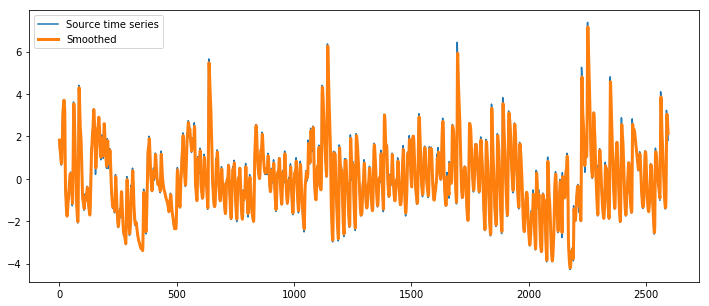

In [51]:
smoothed_output=Rolling_T2(3)

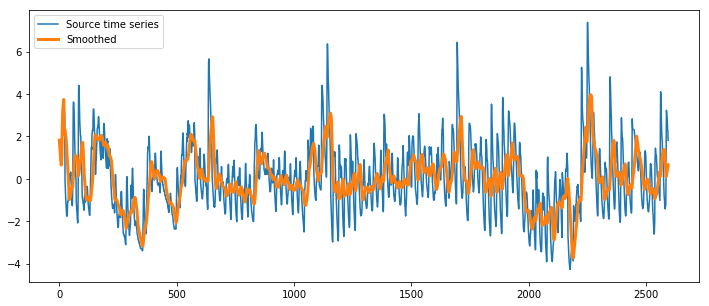

In [60]:
smoothed_output_2=Rolling_T2(20)

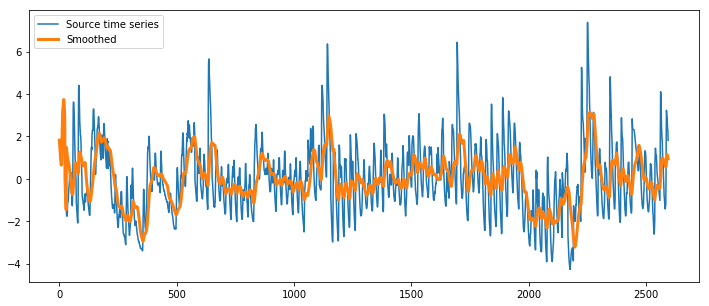

In [53]:
smoothed_output_3=Rolling_T2(30)

#### T2 Gaussian Filter - compare results - summary plots

In [55]:
smoothing_node = PrimaryNode('smoothing') 
smoothing_node.custom_params = {'window_size': 15}

def node_fit_predict(node, input_data):
    """ Fit node and make prediction """
    node.fit(input_data)
    smoothed_output = node.predict(input_data)
    return smoothed_output

smoothed_output = node_fit_predict(smoothing_node, input_data)

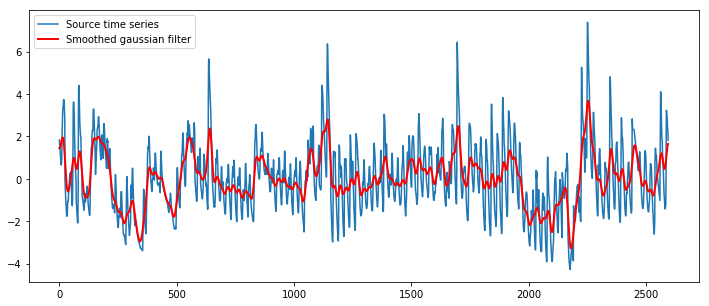

In [56]:
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 8}
smoothed_gaussian = node_fit_predict(gaussian_node, input_data)
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()

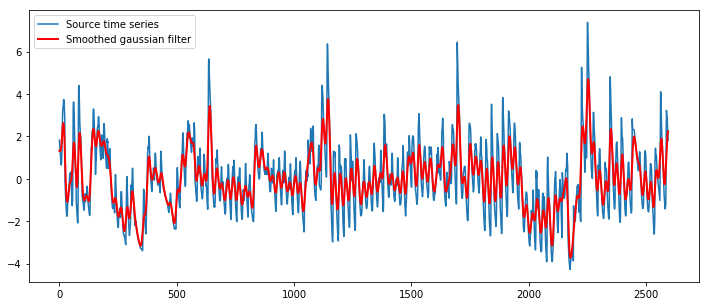

In [57]:
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 5}
smoothed_gaussian_2 = node_fit_predict(gaussian_node, input_data)
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_gaussian_2.idx, smoothed_gaussian_2.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()

#### T2 both filters

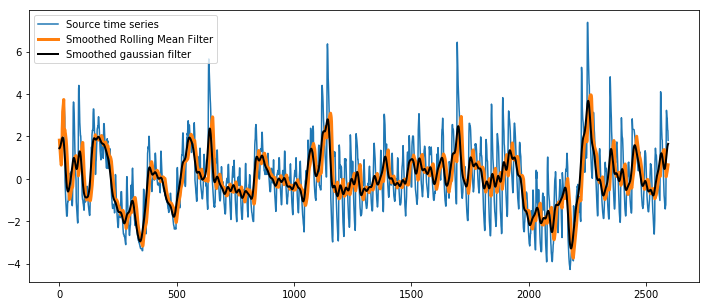

In [61]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_output_2.idx, smoothed_output_2.predict, label='Smoothed Rolling Mean Filter', linewidth=3)
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='black')
plt.legend()
plt.show()

### T_out Filtering

In [62]:
# Data preperation
# Convert into numpy array first
time_series_out=np.array(data_stationary["T_out"])
#FEDOT data preparation
# Define task - time series forecasting
# and forecast horizon 
task=Task (TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=25))
input_data_out = InputData(idx=np.arange(0, len(time_series_out)),
features=time_series_out, target=time_series_out,
task=task, data_type=DataTypesEnum.ts)

#### T out: Rolling mean

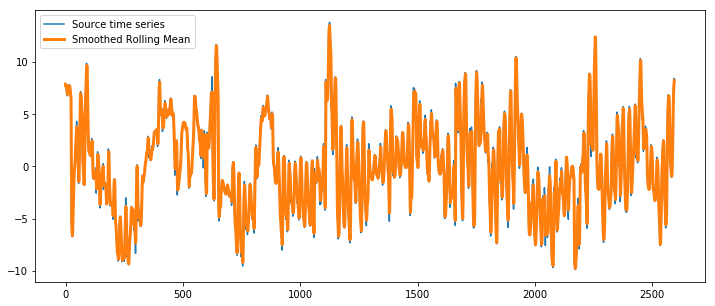

In [63]:
# Rolling mean window smoothing
smoothing_node_out = PrimaryNode('smoothing')
smoothing_node_out.custom_params = {'window_size': 3}
def node_fit_predict(node, input_data_out):
    """ Fit node and make prediction """
    node.fit(input_data_out)
    smoothed_output = node.predict(input_data_out)
    return smoothed_output
smoothed_output_out = node_fit_predict(smoothing_node_out, input_data_out)
plt.plot(input_data_out.idx, input_data_out.target, label='Source time series')
plt.plot(smoothed_output_out.idx, smoothed_output_out.predict, label='Smoothed Rolling Mean', linewidth=3)
plt.legend()
plt.show()

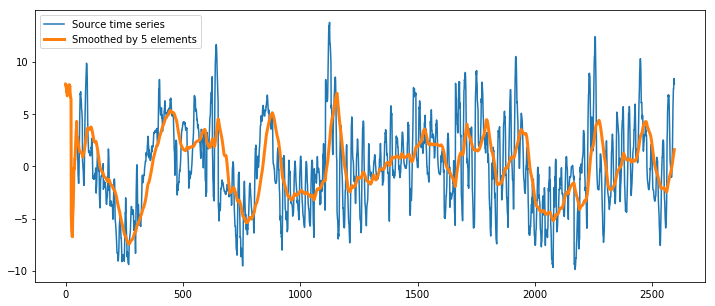

In [67]:
# Rolling mean window smoothing
smoothing_node_out = PrimaryNode('smoothing')
smoothing_node_out.custom_params = {'window_size': 50}
def node_fit_predict(node, input_data_out):
    """ Fit node and make prediction """
    node.fit(input_data_out)
    smoothed_output = node.predict(input_data_out)
    return smoothed_output
smoothed_output_out_1 = node_fit_predict(smoothing_node_out, input_data_out)
plt.plot(input_data_out.idx, input_data_out.target, label='Source time series')
plt.plot(smoothed_output_out_1.idx, smoothed_output_out_1.predict, label='Smoothed by 5 elements', linewidth=3)
plt.legend()
plt.show()

#### Tout: Gaussian filter

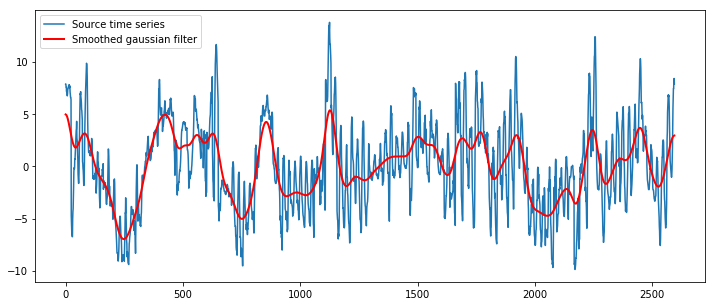

In [68]:
gaussian_node_out = PrimaryNode('gaussian_filter') 
gaussian_node_out.custom_params = {'sigma': 20}
smoothed_gaussian_out_1 = node_fit_predict(gaussian_node_out, input_data_out)
plt.plot(input_data_out.idx, input_data_out.target, label='Source time series')
plt.plot(smoothed_gaussian_out_1.idx, smoothed_gaussian_out_1.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()

#### T_out : both filters

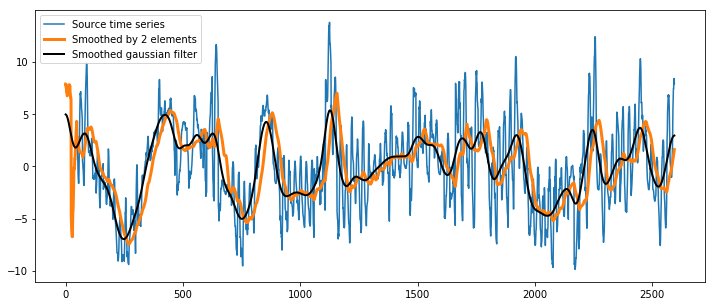

In [69]:
plt.plot(input_data_out.idx, input_data_out.target, label='Source time series')
plt.plot(smoothed_output_out_1.idx, smoothed_output_out_1.predict, label='Smoothed by 2 elements', linewidth=3)
plt.plot(smoothed_gaussian_out_1.idx, smoothed_gaussian_out_1.predict, label='Smoothed gaussian filter', linewidth=2, c='black')
plt.legend()
plt.show()

## Step 05 : Spectral density function with and without filtering
To analyze results after filtering

In [72]:
def Spec_Den_Fun(data,variable,name):
    window_size = 50
    blackman = signal.blackman(M=window_size)
    bartlett = signal.hanning(M=window_size)
    print(len(data))
    f, Pxx_den = signal.welch(variable, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
    f_window, Pxx_den_window = signal.welch(variable, fs=1, window = blackman, nfft = 1000, scaling='spectrum')
    f_window_bart, Pxx_den_window_bart = signal.welch(variable, fs=1, window = bartlett, nfft = 1000, scaling='spectrum')
    plt.plot(f, Pxx_den, linewidth=4)
    #plt.plot(f_window, Pxx_den_window)
    #plt.plot(f_window_bart, Pxx_den_window_bart)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlim((0,0.16))
    plt.title("Spectual Density Function "+ name)
    plt.show()

#### T2

2596


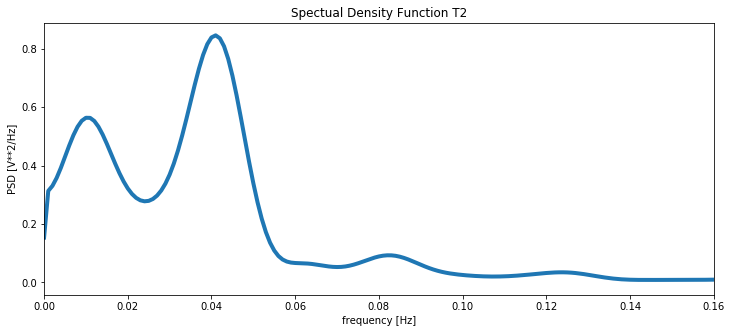

In [73]:
## Spectral density function T2 without filtering
Spec_Den_Fun(data_stationary,data_stationary["T2"],'T2')

2596


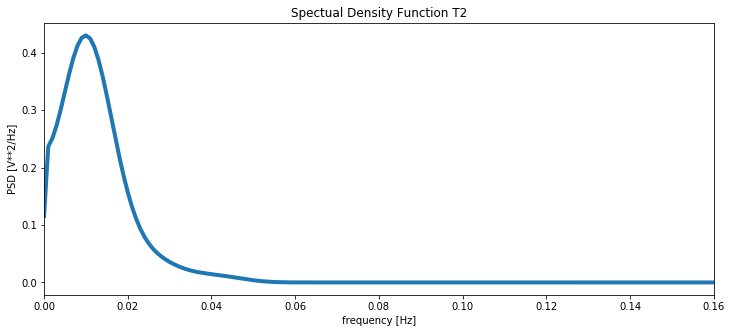

In [74]:
## Spectral density function T2 without filtering
Spec_Den_Fun(smoothed_gaussian.predict,smoothed_gaussian.predict,'T2')
# In the following figure, firstly, we can notice the difference between
# filterd and non filtered specctual
# In addition, we can see that the right tail is long, which mean it is 
# possible to predict long period of time.

#### T_out

2596


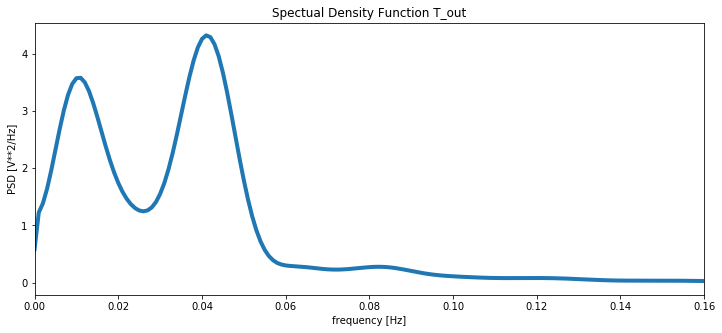

In [75]:
## Spectral density function Tout without filtering
Spec_Den_Fun(data_stationary,data_stationary["T_out"],'T_out')

2596


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  after removing the cwd from sys.path.


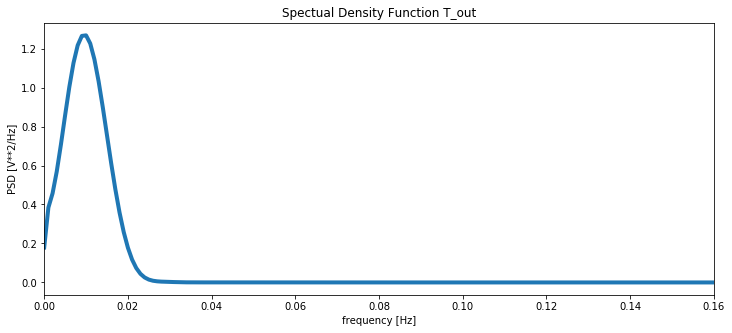

In [168]:
## Spectral density function Tout with filtering
Spec_Den_Fun(smoothed_gaussian_out_1.predict,smoothed_gaussian_out_1.predict,'T_out')

## Step 06: Built auto-regression model filtered and non-filtered data.
To analyze residual error and to define appropriate order of model.


### T2 variable

#### T2 not filttered arima model

In [83]:
# Convert into numpy array first
time_series_reg = np.array(data_stationary['T2'])
(time_series_reg).reshape(2596 ,1)
# Define task - time series forecasting
# and forecast horizon 
task_reg = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=300)) #####foecast length use it to extend the train data for the ARIMA extending prediction line

input_data_reg = InputData(idx=np.arange(0, len(time_series_reg)),
                       features=time_series_reg, target=time_series_reg,
                       task=task_reg, data_type=DataTypesEnum.ts)
# Partitioning Dataset
train, test = train_test_data_setup(input_data_reg)

In [85]:
# Creating pipeline
pipeline = Pipeline(PrimaryNode('ar'))
pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=train,
                                        iterations=500, timeout=5,
                                        cv_folds=2, validation_blocks=1)

Start pipeline tuning
Hyperparameters optimization start
  8%|▊         | 39/500 [05:02<59:30,  7.75s/trial, best loss: 1.2399667756348405]  
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 1.240 equal or smaller than initial (+ 5% deviation) 1.349
Tuning was finished


Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False


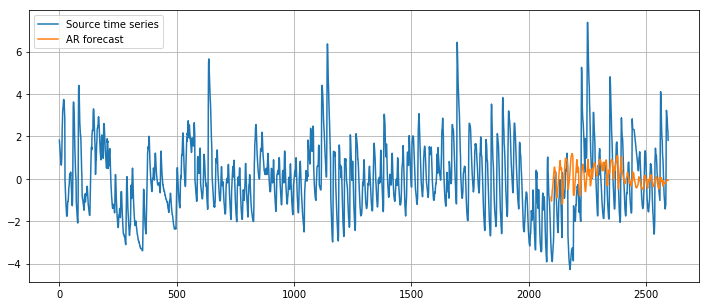

In [86]:
# Fitting Data
fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='AR forecast')
plt.grid()
plt.legend()
plt.show()

#### T2 not filttered SARIMA and AIC model

In [88]:
### other way
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs= range(0,1)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print (u"Models to analyse by AIC:", len(parameters_list))

Models to analyse by AIC: 72


In [89]:
results = []
best_aic = float("inf")
for param in parameters_list:
    # trying fitting the data to SARIMAX model with different order/seasonal order
    # to try to find the best coefficients
    #try except for the case of wrong parameters
    try:
        model =sm.tsa.statespace.SARIMAX(np.array(data_stationary['T2']), order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #print wrong parameters and go on
    # AIC criteria:
    except BaseException as ex:
        continue
    aic = model.aic
    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [90]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
69  (5, 4, 1, 0)  3061.439944
71  (5, 5, 1, 0)  3062.787212
59  (4, 5, 1, 0)  3107.194353
67  (5, 3, 1, 0)  3116.606354
57  (4, 4, 1, 0)  3130.497872


In [91]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 2596
Model:             SARIMAX(5, 1, 4)x(1, 1, [], 12)   Log Likelihood               -1519.720
Date:                             Sun, 28 Nov 2021   AIC                           3061.440
Time:                                     11:20:13   BIC                           3125.864
Sample:                                          0   HQIC                          3084.790
                                            - 2596                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5351      0.011    -47.786      0.000      -0.557      -0.513
ar.L2          0.3344      

In [100]:
best_model.fittedvalues

array([0.        , 1.82642258, 1.65099548, ..., 2.06425801, 2.12746801,
       1.92656925])

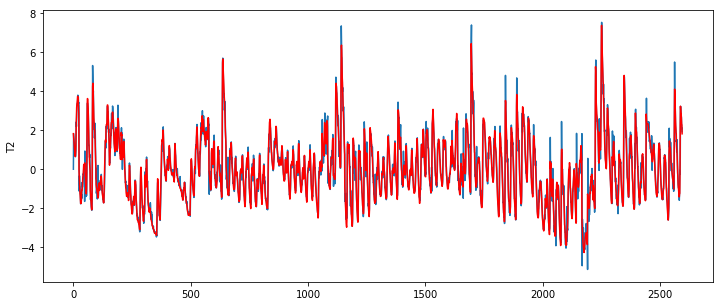

In [107]:
plt.plot(best_model.fittedvalues)
plt.plot(data_stationary['T2'],color='r')
plt.ylabel('T2')
plt.show()

we can see that the prediction for the existed data is good, the difference between statisrical models and machine learning models, is that statistical models are not so affected by the overfitting, so we can simply compare the result for train sample and if statistical model repressent (cover) the training data well --> the model has a strict structure and we can use it for forecasting the future

#### T2 filttered

In [134]:
results_2 = []
best_aic = float("inf")
for param in parameters_list:
    # trying fitting the data to SARIMAX model with different order/seasonal order
    # to try to find the best coefficients
    #try except for the case of wrong parameters
    try:
        model =sm.tsa.statespace.SARIMAX(smoothed_gaussian.predict, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #print wrong parameters and go on
    # AIC criteria:
    except BaseException as ex:
        continue
    aic = model.aic
    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results_2.append([param, model.aic])

In [135]:
result_table_2 = pd.DataFrame(results_2)
result_table_2.columns = ['parameters', 'aic']
print(result_table_2.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
59  (5, 4, 1, 0) -44381.236735
48  (4, 0, 0, 0) -43953.539039
53  (4, 4, 1, 0) -43869.662440
51  (4, 2, 0, 0) -38329.419257
57  (5, 3, 0, 0) -34483.441149


In [136]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 2596
Model:             SARIMAX(5, 1, 4)x(1, 1, [], 12)   Log Likelihood               22201.618
Date:                             Sun, 28 Nov 2021   AIC                         -44381.237
Time:                                     13:37:58   BIC                         -44316.813
Sample:                                          0   HQIC                        -44357.887
                                            - 2596                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          4.5776   3.71e-13   1.23e+13      0.000       4.578       4.578
ar.L2         -8.4437   9.1

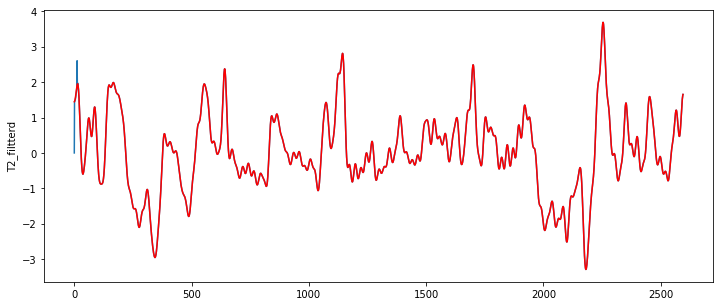

In [137]:
plt.plot(best_model.fittedvalues)
plt.plot(smoothed_gaussian.predict,color='r')
plt.ylabel('T2_filtterd')
plt.show()

### T_out

#### T_out non-flittered SARIMA

In [138]:
results_3 = []
best_aic = float("inf")
for param in parameters_list:
    # trying fitting the data to SARIMAX model with different order/seasonal order
    # to try to find the best coefficients
    #try except for the case of wrong parameters
    try:
        model =sm.tsa.statespace.SARIMAX(np.array(data_stationary['T_out']), order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #print wrong parameters and go on
    # AIC criteria:
    except BaseException as ex:
        continue
    aic = model.aic
    # save best model, aic, parameters
    if (aic < best_aic):
        best_model_3 = model
        best_aic = aic
        best_param_3 = param
    results_3.append([param, model.aic])

In [140]:
result_table_3 = pd.DataFrame(results_3)
result_table_3.columns = ['parameters', 'aic']
print(result_table_3.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
69  (5, 4, 1, 0)  7806.110297
59  (4, 5, 1, 0)  7809.959409
57  (4, 4, 1, 0)  7820.684552
71  (5, 5, 1, 0)  7832.419742
47  (3, 5, 1, 0)  7886.538547


In [141]:
print(best_model_3.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 3306
Model:             SARIMAX(5, 1, 4)x(1, 1, [], 12)   Log Likelihood               -3892.055
Date:                             Sun, 28 Nov 2021   AIC                           7806.110
Time:                                     13:50:27   BIC                           7873.205
Sample:                                          0   HQIC                          7830.130
                                            - 3306                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0531      0.051      1.036      0.300      -0.047       0.154
ar.L2          1.1656      

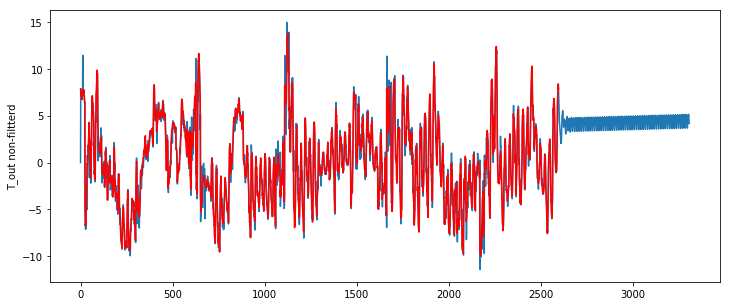

In [142]:
plt.plot(best_model_3.fittedvalues)
plt.plot(data_stationary['T_out'],color='r')
plt.ylabel('T_out non-filtterd')
plt.show()

#### T_out flittered SARIMA

In [143]:
results_4 = []
best_aic = float("inf")
for param in parameters_list:
    # trying fitting the data to SARIMAX model with different order/seasonal order
    # to try to find the best coefficients
    #try except for the case of wrong parameters
    try:
        model =sm.tsa.statespace.SARIMAX(smoothed_gaussian_out_1.predict, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #print wrong parameters and go on
    # AIC criteria:
    except BaseException as ex:
        continue
    aic = model.aic
    # save best model, aic, parameters
    if (aic < best_aic):
        best_model_4 = model
        best_aic = aic
        best_param_4 = param
    results_4.append([param, model.aic])

In [144]:
result_table_4 = pd.DataFrame(results_4)
result_table_4.columns = ['parameters', 'aic']
print(result_table_4.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
40  (3, 3, 0, 0) -48294.638948
42  (3, 4, 0, 0) -48228.605028
48  (4, 3, 0, 0) -48084.423153
44  (3, 5, 0, 0) -48047.760391
52  (4, 5, 0, 0) -48046.356939


In [145]:
print(best_model_4.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 2596
Model:             SARIMAX(3, 1, 3)x(0, 1, [], 12)   Log Likelihood               24154.319
Date:                             Sun, 28 Nov 2021   AIC                         -48294.639
Time:                                     14:40:37   BIC                         -48253.642
Sample:                                          0   HQIC                        -48279.780
                                            - 2596                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.9732      0.000      1e+04      0.000       2.973       2.974
ar.L2         -2.9527      

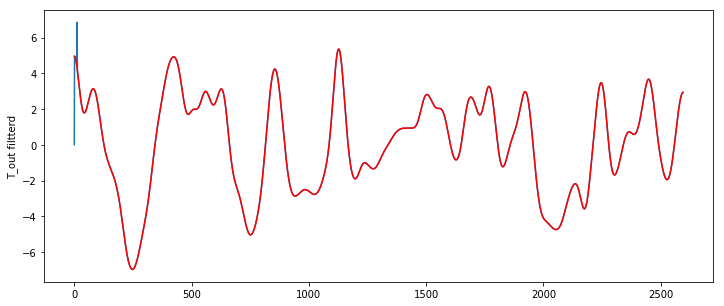

In [146]:
plt.plot(best_model_4.fittedvalues)
plt.plot(smoothed_gaussian_out_1.predict,color='r')
plt.ylabel('T_out filtterd')
plt.show()

## Step 07: Build model in a form of linear dynamical system, using chosen predictors.
To analyze residual error and to define appropriate order of model.

### T2 based on RH2 and T6

In [225]:
# Data preprocessing for FEDOT
def wrap_into_input(forecast_length, feature_time_series, target_time_series):
    """ Convert data for FEDOT framework """
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))
    
    input_data = InputData(idx=np.arange(0, len(target_time_series)),
                           features=feature_time_series, target=target_time_series,
                           task=task, data_type=DataTypesEnum.ts)
    
    return input_data
forecast_length = 200
ts_1 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(df_sample_colomn_energydata['T2']),
                       target_time_series=np.array(df_sample_colomn_energydata['T6']))

ts_2 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(df_sample_colomn_energydata['T2']),
                       target_time_series=np.array(df_sample_colomn_energydata['T5']))

dataset = MultiModalData({
    'data_source_ts/Hsig': ts_1,
    'data_source_ts/RTpeak': ts_2
})

In [226]:
train, test = train_test_data_setup(dataset)

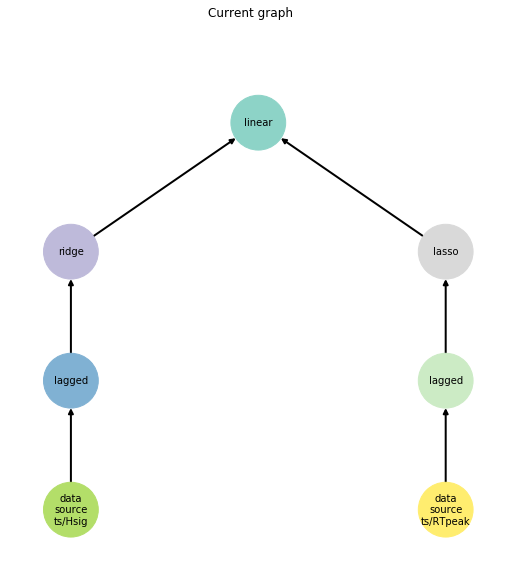

In [227]:
def create_multisource_pipeline():
    """ Generate pipeline with several data sources """
    node_source_1 = PrimaryNode('data_source_ts/Hsig')
    node_source_2 = PrimaryNode('data_source_ts/RTpeak')

    node_lagged_1 = SecondaryNode('lagged', nodes_from=[node_source_1])
    node_lagged_1.custom_params = {'window_size': 150}
    node_lagged_2 = SecondaryNode('lagged', nodes_from=[node_source_2])
      
    node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_1])
    node_lasso = SecondaryNode('lasso', nodes_from=[node_lagged_2])
    
    node_final = SecondaryNode('linear', nodes_from=[node_ridge, node_lasso])
    pipeline = Pipeline(node_final)
    return pipeline

pipeline = create_multisource_pipeline()
pipeline.show()

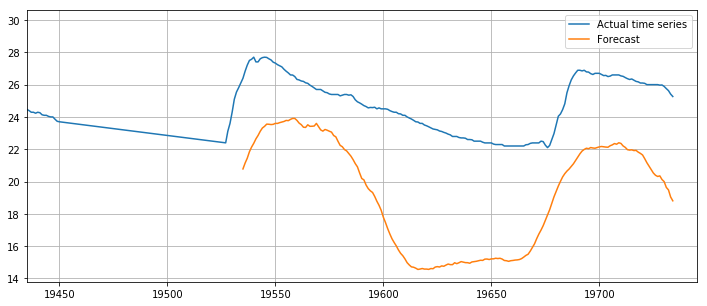

In [230]:
pipeline.fit(train)
forecast = pipeline.predict(test)

train_length = len(df_sample_colomn_energydata['T2']) - forecast_length

plt.plot(df_sample_colomn_energydata['T2'], label='Actual time series')
plt.plot(np.arange(train_length, train_length + forecast_length), 
        np.ravel(forecast.predict), label='Forecast')
plt.xlim(train_length-100, len(df_sample_colomn_energydata['T2'])+10)
plt.legend()
plt.grid()
plt.show()

### T_out based on T5 and T6

In [231]:
Tout_ts_1 = wrap_into_input(forecast_length=forecast_length, 
                       target_time_series=np.array(df_sample_colomn_energydata['T_out']),
                       feature_time_series=np.array(df_sample_colomn_energydata['T6']))

T6outts_2 = wrap_into_input(forecast_length=forecast_length, 
                       target_time_series=np.array(df_sample_colomn_energydata['T_out']),
                       feature_time_series=np.array(df_sample_colomn_energydata['T5']))

dataset_out = MultiModalData({
    'data_source_ts/Hsig': ts_1,
    'data_source_ts/RTpeak': ts_2
})

In [232]:
train_out, test_out = train_test_data_setup(dataset_out)

In [233]:
pipeline_out = create_multisource_pipeline()

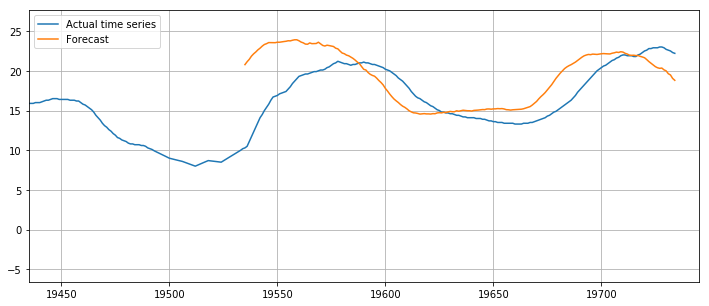

In [234]:
forecast_length_out=200
pipeline_out.fit(train_out)
forecast_out = pipeline.predict(test_out)

train_length_out = len(df_sample_colomn_energydata['T_out']) - forecast_length_out

plt.plot(df_sample_colomn_energydata['T_out'], label='Actual time series')
plt.plot(np.arange(train_length_out, train_length_out + forecast_length_out), 
         np.ravel(forecast_out.predict), label='Forecast')
plt.xlim(train_length_out - 100, len(df_sample_colomn_energydata['T_out']) + 10)
plt.legend()
plt.grid()
plt.show()